In [77]:
# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

import jax.numpy as np
import jax.scipy as sc
import jax.random as random
import jax.experimental.loops as loops
import jax.lax as lax
import matplotlib.pyplot as plt
from jax import jit, jacrev, jacfwd, vmap, grad

In [78]:
cbm = load_presaved_model("Miyake17", production_rate_units="atoms/cm^2/s", flow_rate_units="1/yr" )
cbm.compile()

In [88]:
def construct_model(cbm=cbm):
    indexes = np.where(cbm._fluxes != 0)
    indexes = np.array(indexes).T

    @jit
    def parse_parameters(parameters, indexes=indexes):
        dimensions = parameters.shape[0]
        with loops.Scope() as scope:
            scope.template = np.zeros((4, 4), dtype=np.float64)
            for parameter in scope.range(dimensions):
                i, j = indexes[parameter]
                scope.template = scope.template.at[i, j].set(parameters[parameter])
        return scope.template

    return parse_parameters

In [89]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = np.array([row.strip().split(" ") for row in data], dtype=np.float64)
        return data.T


In [90]:
parse_parameters = construct_model(cbm)
parameters = random.uniform(random.PRNGKey(1), (10, 1))

In [228]:
@jit
def analytic_solution(parameters, time_out, /, decay=cbm._decay_matrix, parser=parse_parameters):
    """
    This is the analytic solution itself.
    Parameters: 
        
    Returns:
    """
    # So I need to work here on reducing to the Miyake17 model and also fixing the event area and the production.
    # I also need to work on the equilibrium position. So at the moment I have the problem that the equilibrium has something to do with the inverse of the transfer matrix 
    dimensions = decay.shape[0]

    #! I want to fix these and infer the other parameters 
    # start_date = parameters[0]
    # event_area = parameters[1]
    # production = parameters[2]
    # production = np.array([1 - production, production, *np.zeros(dimensions - 2)], dtype=np.float64)
    flow_sizes = parameters[dimensions:]
    reservoirs = parameters[:dimensions]

    # initial_position = event_area * production

    # Consider moving this into less lines and profiling
    transfer_matrix = parser(flow_sizes)
    transfer_matrix /= reservoirs.reshape(-1, 1)
    transfer_matrix = transfer_matrix.T - np.diag(np.sum(transfer_matrix, axis=1))
    transfer_matrix -= decay

    # So basically I will have many more parameters at this point. I might try a conditional statement but jit could have other plans. 
    # I still need to look into vmap(expm)
    initial_position = np.zeros(dimensions, dtype=np.float64)
    initial_position = initial_position.at[:2].set([28.0, 12.0])

    @vmap
    def vmap_util(t, /, transfer_matrix=transfer_matrix, y0=initial_position, start=774.86):
        return sc.linalg.expm((t - start) * transfer_matrix) @ y0

    impulse_solution = vmap_util(time_out)
    steady_solution = np.zeros((impulse_solution.shape))
    condition = (time_out > 774.86).reshape(-1, 1)
    
    return np.where(condition, impulse_solution, steady_solution)


In [219]:
data = load("miyake12.csv")
data = data.at[1].add(-np.mean(data[1, 1:4]))

In [231]:
@partial(jit, static_argnums=(1, 2))
def loss(parameters, /, analytic_solution=analytic_solution, data=data):
    """
    Computes the log likelihood of a set of parameters in the parameter space
    """
    # in_bounds = 0.0
    # in_bounds = np.any((parameters[2:] < 0.0) | (parameters[2:] > 1.0)) * np.inf
    analytic_data = analytic_solution(parameters, data[0])
    chi_sq = np.sum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)
    return chi_sq

In [221]:
flat_transfer = cbm._corrected_fluxes.reshape(-1)    # Flattens into a 1d array
transf_params = np.take(flat_transfer, np.array(np.nonzero(flat_transfer)))
parameters = np.concatenate([cbm._reservoir_content.T, transf_params.T]).reshape(-1)

In [236]:
gradient = jit(grad(loss))
hessian = jit(jacfwd(jacrev(loss)))

In [234]:
%%timeit
loss(parameters)

166 µs ± 6.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [237]:
%%timeit
gradient(parameters)

599 µs ± 218 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [238]:
%%timeit
hessian(parameters)

4.55 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [239]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=True)
mcmc.run(random.PRNGKey(11), init_params=parameters)

sample: 100%|██████████| 600/600 [06:53<00:00,  1.45it/s, 1023 steps of size 1.04e-03. acc. prob=0.95]


In [240]:
test = mcmc.get_samples()

In [241]:
import seaborn as sns
sns.set()

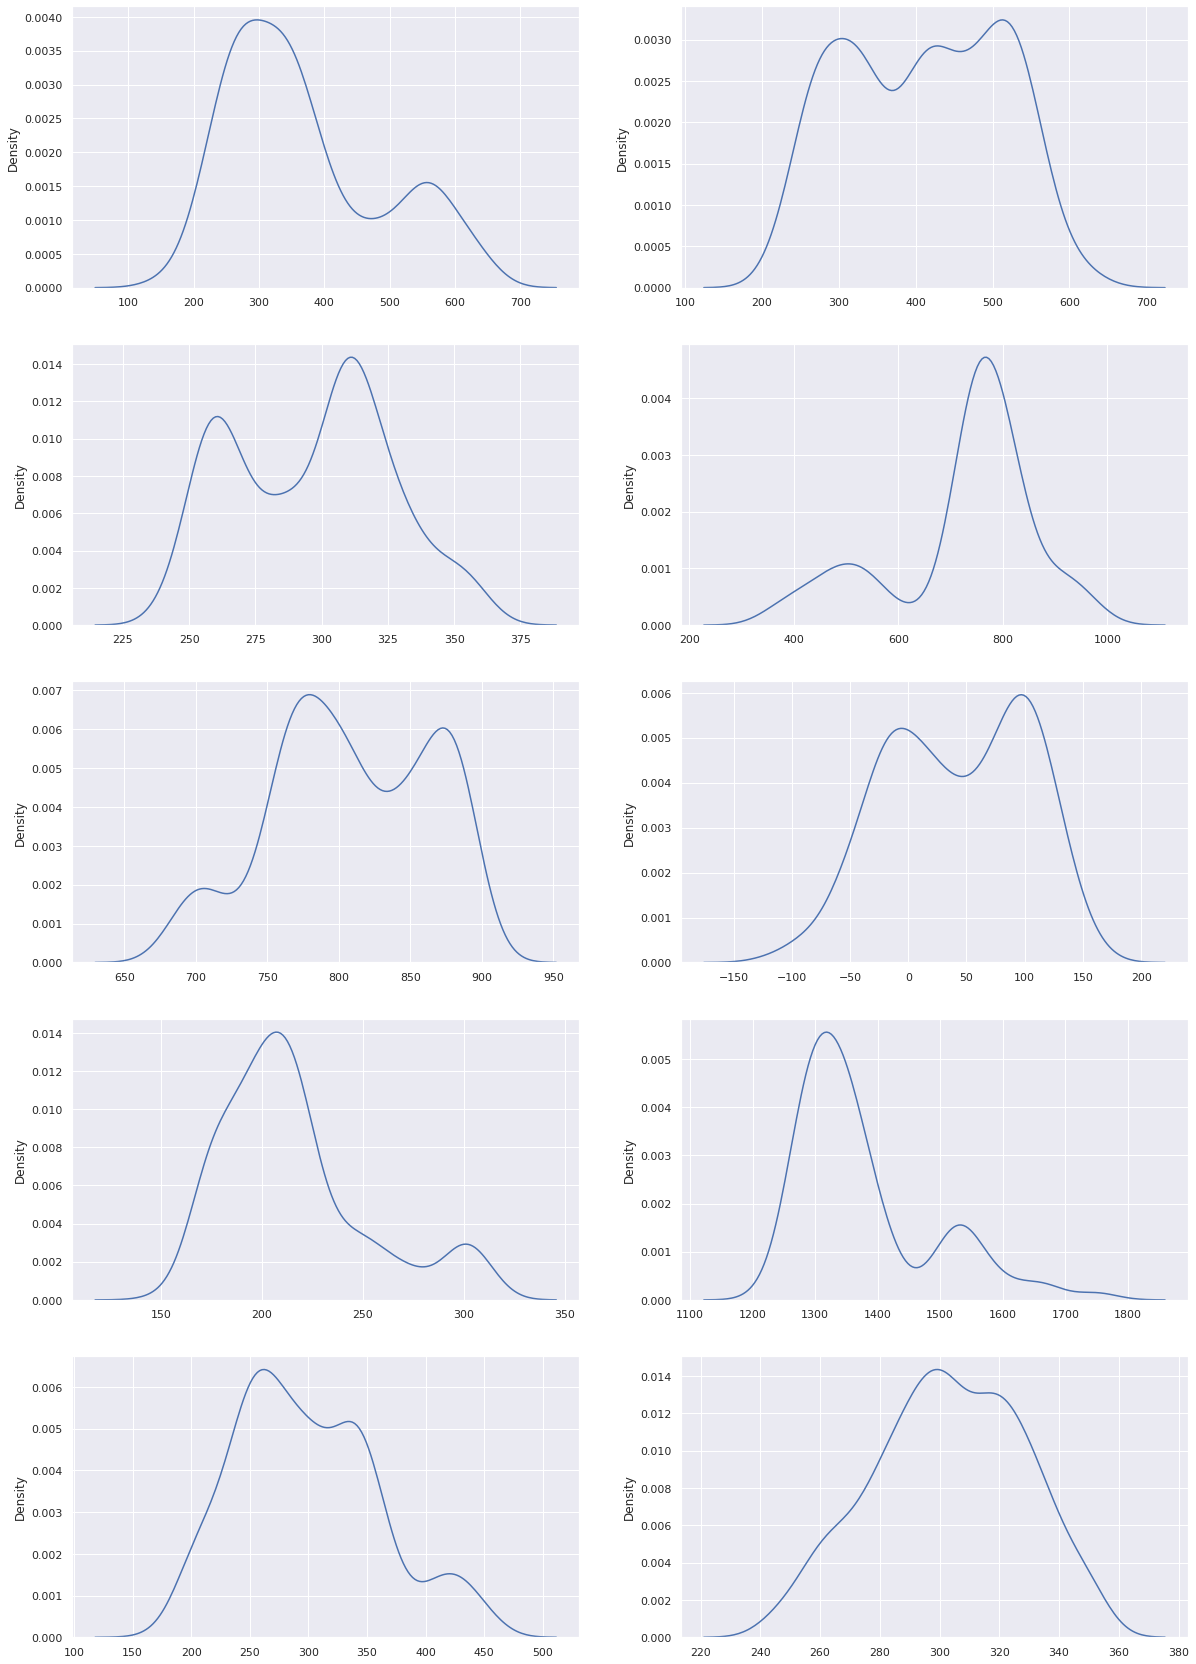

In [247]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
for index, variable in enumerate(test.T):
    axis = axes[index % 5][index % 2]
    sns.kdeplot(test.T[index], ax=axis)

In [248]:
omg = np.mean(test, axis=0)

In [252]:
inferred_reservoirs = omg[:4]
inferred_reservoirs

DeviceArray([ 368.47215442,  724.28785024,  808.48876622, 1376.72497749],            dtype=float64)

In [253]:
cbm._reservoir_content

DeviceArray([[ 112.5,  637.5,  900. , 1600. ]], dtype=float64)

In [257]:
inferred_fluxes = omg[4:]
parse_parameters(inferred_fluxes)

DeviceArray([[  0.        , 299.06371198,   0.        ,   0.        ],
             [409.63226118,   0.        , 296.5538299 ,  42.48636089],
             [  0.        , 215.80378902,   0.        ,   0.        ],
             [  0.        , 302.98383243,   0.        ,   0.        ]],            dtype=float64)

In [256]:
cbm._corrected_fluxes

DeviceArray([[  0.        , 131.28039375,   0.        ,   0.        ],
             [131.28039375,   0.        , 135.2585875 ,  64.68888967],
             [  0.        , 135.2585875 ,   0.        ,   0.        ],
             [  0.        ,  64.68888967,   0.        ,   0.        ]],            dtype=float64)

In [258]:
ana = analytic_solution(omg, data[0])

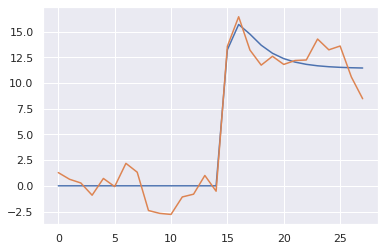

In [259]:
plt.plot(ana[:, 1])
plt.plot(data[1])

In [547]:
loss(omg)

DeviceArray(757.90314494, dtype=float64)

So I need to think about how I want to do the inference from here. Removing the single parameter and changing the equilibrium position. I will start with the equilibrium position. Then I will remove the parameter then I will repeat the `NUTS` sampling. I also need to work on pushing my changes to `origin/main` which means setting `ticktack` back up to work without the fucking `solver` bullshit